# Legendre Memory Units

## Start
To reset the notebook, run from this point

In [26]:
%reset -f

## Imports

In [27]:
import numpy as np

import torch
from torch import nn
from torch import fft
from torch.nn import init
from torch.nn import functional as F

from scipy.signal import cont2discrete

## Functions

In [28]:
def leCunUniform(tensor):
    """ 
        LeCun Uniform Initializer
        References: 
        [1] https://keras.rstudio.com/reference/initializer_lecun_uniform.html
        [2] Source code of _calculate_correct_fan can be found in https://pytorch.org/docs/stable/_modules/torch/nn/init.html
        [3] Yann A LeCun, Léon Bottou, Genevieve B Orr, and Klaus-Robert Müller. Efficient backprop. In Neural networks: Tricks of the trade, pages 9–48. Springer, 2012
    """
    fan_in = init._calculate_correct_fan(tensor, "fan_in")
    limit = np.sqrt(3. / fan_in)
    init.uniform_(tensor, -limit, limit) # fills the tensor with values sampled from U(-limit, limit)

## Classes

### Single LMU Cell/Unit

In [29]:
class LMUCell(nn.Module):
    """ A single LMU Cell """


    def __init__(self, input_size, hidden_size, memory_size, theta, learn_a = False, learn_b = False, psmnist = False):
        """
        Parameters:
            input_size (int) : 
                Size of the input vector (x_t)
            hidden_size (int) : 
                Size of the hidden vector (h_t)
            memory_size (int) :
                Size of the memory vector (m_t)
            theta (int) :
                The number of timesteps in the sliding window that is represented using the LTI system
            learn_a (boolean) :
                Whether to learn the matrix A (default = False)
            learn_b (boolean) :
                Whether to learn the matrix B (default = False)
            psmnist (boolean) :
                Uses different parameter initializers when training on psMNIST (as specified in the paper)
        """
        
        super(LMUCell, self).__init__()

        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.f = nn.Tanh()

        A, B = self.stateSpaceMatrices(memory_size, theta)
        A = torch.from_numpy(A).float()
        B = torch.from_numpy(B).float()

        if learn_a:
            self.A = nn.Parameter(A)
        else:
            self.register_buffer("A", A)
    
        if learn_b:
            self.B = nn.Parameter(B)
        else:
            self.register_buffer("B", B)

        # Declare Model parameters:
        ## Encoding vectors
        self.e_x = nn.Parameter(torch.empty(1, input_size))
        self.e_h = nn.Parameter(torch.empty(1, hidden_size))
        self.e_m = nn.Parameter(torch.empty(1, memory_size))
        ## Kernels
        self.W_x = nn.Parameter(torch.empty(hidden_size, input_size))
        self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.W_m = nn.Parameter(torch.empty(hidden_size, memory_size))

        self.initParameters(psmnist)


    def initParameters(self, psmnist = False):
        """ Initialize the cell's parameters """

        if psmnist:
            # Initialize encoders
            leCunUniform(self.e_x)
            init.constant_(self.e_h, 0)
            init.constant_(self.e_m, 0)
            # Initialize kernels
            init.constant_(self.W_x, 0)
            init.constant_(self.W_h, 0)
            init.xavier_normal_(self.W_m)
        else:
            # Initialize encoders
            leCunUniform(self.e_x)
            leCunUniform(self.e_h)
            init.constant_(self.e_m, 0)
            # Initialize kernels
            init.xavier_normal_(self.W_x)
            init.xavier_normal_(self.W_h)
            init.xavier_normal_(self.W_m)


    def stateSpaceMatrices(self, memory_size, theta):
        """ Returns the discretized state space matrices A and B """

        Q = np.arange(memory_size, dtype = np.float64).reshape(-1, 1)
        R = (2*Q + 1) / theta
        i, j = np.meshgrid(Q, Q, indexing = "ij")

        # Continuous
        A = R * np.where(i < j, -1, (-1.0)**(i - j + 1))
        B = R * ((-1.0)**Q)
        C = np.ones((1, memory_size))
        D = np.zeros((1,))

        # Convert to discrete
        A, B, C, D, dt = cont2discrete(
            system = (A, B, C, D), 
            dt = 1.0, 
            method = "zoh"
        )
        
        return A, B


    def forward(self, x, state):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, input_size]
            state (tuple): 
                h (torch.tensor) : [batch_size, hidden_size]
                m (torch.tensor) : [batch_size, memory_size]
        """

        h, m = state

        # Equation (7) of the paper
        u = F.linear(x, self.e_x) + F.linear(h, self.e_h) + F.linear(m, self.e_m) # [batch_size, 1]

        # Equation (4) of the paper
        m = F.linear(m, self.A) + F.linear(u, self.B) # [batch_size, memory_size]

        # Equation (6) of the paper
        h = self.f(
            F.linear(x, self.W_x) +
            F.linear(h, self.W_h) + 
            F.linear(m, self.W_m)
        ) # [batch_size, hidden_size]

        return h, m

### LMU Layer

In [30]:
class LMU(nn.Module):
    """ An LMU layer """

    def __init__(self, input_size, hidden_size, memory_size, theta, learn_a = False, learn_b= False, psmnist = False):
        """
        Parameters:
            input_size (int) : 
                Size of the input vector (x_t)
            hidden_size (int) : 
                Size of the hidden vector (h_t)
            memory_size (int) :
                Size of the memory vector (m_t)
            theta (int) :
                The number of timesteps in the sliding window that is represented using the LTI system
            learn_a (boolean) :
                Whether to learn the matrix A (default = False)
            learn_b (boolean) :
                Whether to learn the matrix B (default = False)
            psmnist (boolean) :
                Uses different parameter initializers when training on psMNIST (as specified in the paper)
        """

        super(LMU, self).__init__()
        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.cell = LMUCell(input_size, hidden_size, memory_size, theta, learn_a, learn_b, psmnist)


    def forward(self, x, state = None):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, seq_len, input_size]
            state (tuple) : (default = None) 
                h (torch.tensor) : [batch_size, hidden_size]
                m (torch.tensor) : [batch_size, memory_size]
        """
        
        # Assuming batch dimension is always first, followed by seq. length as the second dimension
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initial state (h_0, m_0)
        if state == None:
            h_0 = torch.zeros(batch_size, self.hidden_size)
            m_0 = torch.zeros(batch_size, self.memory_size)
            if x.is_cuda:
                h_0 = h_0.cuda()
                m_0 = m_0.cuda()
            state = (h_0, m_0)

        # Iterate over the timesteps
        output = []
        for t in range(seq_len):
            x_t = x[:, t, :] # [batch_size, input_size]
            h_t, m_t = self.cell(x_t, state)
            state = (h_t, m_t)
            output.append(h_t)

        output = torch.stack(output) # [seq_len, batch_size, hidden_size]
        output = output.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]

        return output, state # state is (h_n, m_n) where n = seq_len

### LMU - FFT

In [31]:
class LMUFFT(nn.Module):

    def __init__(self, input_size, hidden_size, memory_size, seq_len, theta):

        super(LMUFFT, self).__init__()

        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.seq_len = seq_len
        self.theta = theta

        self.W_u = nn.Linear(in_features = input_size, out_features = 1)
        self.f_u = nn.ReLU()
        self.W_h = nn.Linear(in_features = memory_size + input_size, out_features = hidden_size)
        self.f_h = nn.ReLU()

        A, B = self.stateSpaceMatrices()
        self.register_buffer("A", A) # [memory_size, memory_size]
        self.register_buffer("B", B) # [memory_size, 1]

        H, fft_H = self.impulse()
        self.register_buffer("H", H) # [memory_size, seq_len]
        self.register_buffer("fft_H", fft_H) # [memory_size, seq_len + 1]


    def stateSpaceMatrices(self):
        """ Returns the discretized state space matrices A and B """

        Q = np.arange(self.memory_size, dtype = np.float64).reshape(-1, 1)
        R = (2*Q + 1) / self.theta
        i, j = np.meshgrid(Q, Q, indexing = "ij")

        # Continuous
        A = R * np.where(i < j, -1, (-1.0)**(i - j + 1))
        B = R * ((-1.0)**Q)
        C = np.ones((1, self.memory_size))
        D = np.zeros((1,))

        # Convert to discrete
        A, B, C, D, dt = cont2discrete(
            system = (A, B, C, D), 
            dt = 1.0, 
            method = "zoh"
        )

        # To torch.tensor
        A = torch.from_numpy(A).float() # [memory_size, memory_size]
        B = torch.from_numpy(B).float() # [memory_size, 1]
        
        return A, B


    def impulse(self):
        """ Returns the matrices H and the 1D Fourier transform of H (Equations 23, 26 of the paper) """

        H = []
        A_i = torch.eye(self.memory_size)
        for t in range(self.seq_len):
            H.append(A_i @ self.B)
            A_i = self.A @ A_i

        H = torch.cat(H, dim = -1) # [memory_size, seq_len]
        fft_H = fft.rfft(H, n = 2*self.seq_len, dim = -1) # [memory_size, seq_len + 1]

        return H, fft_H


    def forward(self, x):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, seq_len, input_size]
        """

        batch_size, seq_len, input_size = x.shape

        # Equation 18 of the paper
        u = self.f_u(self.W_u(x)) # [batch_size, seq_len, 1]

        # Equation 26 of the paper
        fft_input = u.permute(0, 2, 1) # [batch_size, 1, seq_len]
        fft_u = fft.rfft(fft_input, n = 2*seq_len, dim = -1) # [batch_size, seq_len, seq_len+1]

        # Element-wise multiplication (uses broadcasting)
        # [batch_size, 1, seq_len+1] * [1, memory_size, seq_len+1]
        temp = fft_u * self.fft_H.unsqueeze(0) # [batch_size, memory_size, seq_len+1]

        m = fft.irfft(temp, n = 2*seq_len, dim = -1) # [batch_size, memory_size, seq_len+1]
        m = m[:, :, :seq_len] # [batch_size, memory_size, seq_len]
        m = m.permute(0, 2, 1) # [batch_size, seq_len, memory_size]

        # Equation 20 of the paper (W_m@m + W_x@x  W@[m;x])
        input_h = torch.cat((m, x), dim = -1) # [batch_size, seq_len, memory_size + input_size]
        h = self.f_h(self.W_h(input_h)) # [batch_size, seq_len, hidden_size]

        h_n = h[:, -1, :] # [batch_size, hidden_size]

        return h, h_n

## Example: psMNIST

### Imports and Constants

In [32]:
import random
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [33]:
# Connect to GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
    # Clear cache if non-empty
    torch.cuda.empty_cache()
    # See which GPU has been allotted 
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    DEVICE = "cpu"

Tesla T4


In [34]:
SEED = 0

def setSeed(seed):
    """ Set all seeds to ensure reproducibility """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

setSeed(SEED)

In [35]:
N_x = 1 # dimension of the input, a single pixel
N_t = 784
N_h = 346 # dimension of the hidden state
N_m = 468 # dimension of the memory
N_c = 10 # number of classes 
THETA = 784
N_b = 100 # batch size
N_epochs = 15

### Data

In [36]:
class psMNIST(Dataset):
    """ Dataset that defines the psMNIST dataset, given the MNIST data and a fixed permutation """

    def __init__(self, mnist, perm):
        self.mnist = mnist # also a torch.data.Dataset object
        self.perm  = perm

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        unrolled = img.reshape(-1)
        permuted = unrolled[self.perm]
        permuted = permuted.reshape(-1, 1)
        return permuted, label

### Model

In [37]:
class Model(nn.Module):
    """ A simple model for the psMNIST dataset consisting of a single LMUFFT layer and a single dense classifier """

    def __init__(self, input_size, output_size, hidden_size, memory_size, seq_len, theta):
        super(Model, self).__init__()
        self.lmu_fft = LMUFFT(input_size, hidden_size, memory_size, seq_len, theta)
        self.dropout = nn.Dropout(p = 0.5)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, h_n = self.lmu_fft(x) # [batch_size, hidden_size]
        x = self.dropout(h_n)
        output = self.classifier(x)
        return output # [batch_size, output_size]

### Functions

#### Utils

In [38]:
def disp(img):
    """ Displays an image """
    if len(img.shape) == 3:
        img = img.squeeze(0)
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [39]:
def dispSeq(seq, rows = 8):
    """ Displays a sequence of pixels """
    seq = seq.reshape(rows, -1) # divide the 1D sequence into `rows` rows for easy visualization
    disp(seq)

#### Model

In [40]:
def countParameters(model):
    """ Counts and prints the number of trainable and non-trainable parameters of a model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

In [41]:
def train(model, loader, optimizer, criterion):
    """ A single training epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.train()
    for batch, labels in tqdm(loader):

        torch.cuda.empty_cache()

        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)

        optimizer.zero_grad()

        output = model(batch)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

        preds  = output.argmax(dim = 1)
        y_pred += preds.tolist()
        y_true += labels.tolist()
        epoch_loss += loss.item()

    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

In [42]:
def validate(model, loader, criterion):
    """ A single validation epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(loader):

            torch.cuda.empty_cache()

            batch = batch.to(DEVICE)
            labels = labels.long().to(DEVICE)

            output = model(batch)
            loss = criterion(output, labels)
            
            preds  = output.argmax(dim = 1)
            y_pred += preds.tolist()
            y_true += labels.tolist()
            epoch_loss += loss.item()
            
    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

### Main

#### Data

In [43]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST("/content/", train = True, download = True, transform = transform)
mnist_val   = datasets.MNIST("/content/", train = False, download = True, transform = transform)

perm = torch.load("permutation.pt").long() # created using torch.randperm(784)
ds_train = psMNIST(mnist_train, perm)
ds_val   = psMNIST(mnist_val, perm)

dl_train = DataLoader(ds_train, batch_size = N_b, shuffle = True, num_workers = 2, pin_memory = True)
dl_val   = DataLoader(ds_val, batch_size = N_b, shuffle = True, num_workers = 2, pin_memory = True)

Label: 5


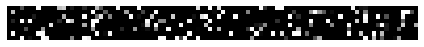

In [44]:
# Example of the data
eg_img, eg_label = ds_train[0]
print("Label:", eg_label)
dispSeq(eg_img)

#### Model

In [45]:
model = Model(
    input_size = N_x, 
    output_size = N_c, 
    hidden_size = N_h, 
    memory_size = N_m, 
    seq_len = N_t, 
    theta = THETA
)
model = model.to(DEVICE)

In [46]:
countParameters(model)

The model has 166,092 trainable parameters and 0 frozen parameters


#### Optimization

In [47]:
optimizer = optim.Adam(params = model.parameters())

In [48]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

In [49]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(N_epochs):
   
    print(f"Epoch: {epoch+1:02}/{N_epochs:02}")

    train_loss, train_acc = train(model, dl_train, optimizer, criterion)
    val_loss, val_acc = validate(model, dl_val, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")
    print()

Epoch: 01/15



Train Loss: 0.706 | Train Acc: 80.22%
Val. Loss: 0.271 |  Val. Acc: 92.42%

Epoch: 02/15



Train Loss: 0.268 | Train Acc: 92.18%
Val. Loss: 0.180 |  Val. Acc: 95.02%

Epoch: 03/15



Train Loss: 0.196 | Train Acc: 94.30%
Val. Loss: 0.135 |  Val. Acc: 96.02%

Epoch: 04/15



Train Loss: 0.157 | Train Acc: 95.42%
Val. Loss: 0.111 |  Val. Acc: 96.65%

Epoch: 05/15



Train Loss: 0.134 | Train Acc: 96.05%
Val. Loss: 0.095 |  Val. Acc: 97.21%

Epoch: 06/15



Train Loss: 0.117 | Train Acc: 96.53%
Val. Loss: 0.086 |  Val. Acc: 97.34%

Epoch: 07/15



Train Loss: 0.105 | Train Acc: 96.85%
Val. Loss: 0.081 |  Val. Acc: 97.47%

Epoch: 08/15



Train Loss: 0.096 | Train Acc: 97.12%
Val. Loss: 0.075 |  Val. Acc: 97.68%

Epoch: 09/15



Train Loss: 0.086 | Train Acc: 97.38%
Val. Loss: 0.072 |  Val. Acc: 97.80%

Epoch: 10/15



Train Loss: 0.079 | Train Acc: 97.54%
Val. Loss: 0.069 |  Val. Acc: 97.87%

Epoch: 11/15



Train Loss: 0.075 | Train Acc: 97.75%
Val. Loss: 0.067 |  Val. Acc: 97.90%

Epoch: 12/15



Train Loss: 0.071 | Train Acc: 97.79%
Val. Loss: 0.066 |  Val. Acc: 97.97%

Epoch: 13/15



Train Loss: 0.066 | Train Acc: 97.91%
Val. Loss: 0.063 |  Val. Acc: 98.12%

Epoch: 14/15



Train Loss: 0.062 | Train Acc: 97.99%
Val. Loss: 0.062 |  Val. Acc: 98.21%

Epoch: 15/15



Train Loss: 0.058 | Train Acc: 98.11%
Val. Loss: 0.064 |  Val. Acc: 98.07%



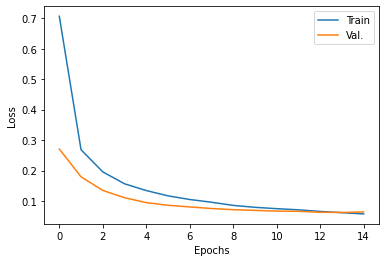

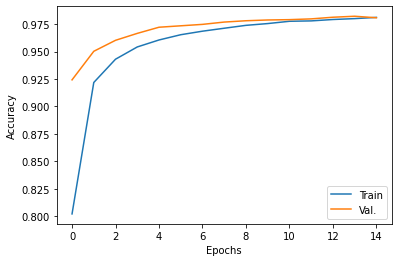

In [50]:
# Learning curves

plt.plot(range(N_epochs), train_losses)
plt.plot(range(N_epochs), val_losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()

plt.plot(range(N_epochs), train_accs)
plt.plot(range(N_epochs), val_accs)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()